# Feature Selection
To ensure optimal model performance, the collected features from the dataset and engineered features are compared and analyzed, to find the optimal set for the best model performance. Dimensionality reducation techniques such as PCA are also explored, to optimize performance and computational cost.

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, roc_curve
)
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Create output directory
output_dir = Path("model_results/consensus_features")
output_dir.mkdir(exist_ok=True, parents=True)
figures_dir = Path("figures/model_results/consensus_features")
figures_dir.mkdir(exist_ok=True, parents=True)

In [60]:
output_dir = Path("selected_features")
output_dir.mkdir(exist_ok=True)
figures_dir = Path("figures/feature_selection")
figures_dir.mkdir(exist_ok=True, parents=True)

# 1. Load Engineered Data

In [61]:
# Load the engineered dataset
data_path = Path("engineered_data/engineered_final_feature_dataset.csv")
df = pd.read_csv(data_path)
print(f"Loaded data with shape: {df.shape}")
df.head()

Loaded data with shape: (26058, 104)


,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,ast_shooting_synergy_away,reb_ast_synergy,scoring_x_defense,log_shooting_var_gap,win_pct_gap_cubed,overall_team_form,binned_momentum,binned_fg_home,binned_reb_gap,binned_log_ast
0,2004-01-02,20300451.0,1.610613e+09,1.610613e+09,2004,1.610613e+09,0.446,0.611,0.400,30.0,...,8.060,29.999995,0.0,0.001847,0.0,0.006801,2,1,3,3
1,2004-01-02,20300458.0,1.610613e+09,1.610613e+09,2004,1.610613e+09,0.409,0.929,0.308,32.0,...,8.184,31.999994,0.0,0.001368,0.0,-0.030286,2,0,3,3
2,2004-01-02,20300454.0,1.610613e+09,1.610613e+09,2004,1.610613e+09,0.470,0.800,0.333,25.0,...,9.760,24.999993,0.0,0.000324,0.0,0.087392,2,2,0,2
3,2004-01-02,20300457.0,1.610613e+09,1.610613e+09,2004,1.610613e+09,0.389,0.947,0.238,26.0,...,7.900,25.999995,0.0,0.000036,0.0,-0.045057,2,0,3,2
4,2004-01-02,20300453.0,1.610613e+09,1.610613e+09,2004,1.610613e+09,0.507,0.640,0.400,17.0,...,9.177,16.999995,0.0,0.004888,0.0,0.058245,2,3,0,0


In [62]:
# Define target variable
target_col = 'HOME_TEAM_WINS'  # Adjust if your column name is different
if target_col not in df.columns:
    # Try to create it if not present
    if 'PTS_home' in df.columns and 'PTS_away' in df.columns:
        df[target_col] = (df['PTS_home'] > df['PTS_away']).astype(int)
        print(f"Created target variable {target_col}")

# %%
# Check for data leakage
print("Checking for potential data leakage...")
leakage_terms = ['POINT_DIFF', 'home_win']
for term in leakage_terms:
    matching_cols = [col for col in df.columns if term in col]
    if matching_cols:
        print(f"Potential leakage columns containing '{term}': {matching_cols}")

# Remove any direct leakage columns
leakage_columns = ['POINT_DIFF', 'ABS_POINT_DIFF']
X = df.drop(columns=[target_col] + [col for col in leakage_columns if col in df.columns])
y = df[target_col]

print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")
print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")

Checking for potential data leakage...
Potential leakage columns containing 'home_win': ['home_win_bin']
Feature matrix shape: (26058, 103), Target vector shape: (26058,)
Target distribution: {1.0: 0.5885332719318443, 0.0: 0.41146672806815565}


In [63]:
# Remove non-numeric columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X = X[numeric_cols]
print(f"Numeric feature matrix shape: {X.shape}")

Numeric feature matrix shape: (26058, 100)


In [64]:
# Identify original vs engineered features
engineered_patterns = ['_diff', 'ratio', 'efficiency', 'synergy', 'momentum', 'advantage', 'gap']
engineered_features = [col for col in X.columns if any(pattern in col.lower() for pattern in engineered_patterns)]
original_features = [col for col in X.columns if col not in engineered_features]

print(f"Original features: {len(original_features)}")
print(f"Engineered features: {len(engineered_features)}")

# Display some examples of each
print("\nSample original features:")
for feature in original_features[:5]:
    print(f"- {feature}")
    
print("\nSample engineered features:")
for feature in engineered_features[:5]:
    print(f"- {feature}")

Original features: 67
Engineered features: 33

Sample original features:
- GAME_ID
- HOME_TEAM_ID
- VISITOR_TEAM_ID
- SEASON
- TEAM_ID_home

Sample engineered features:
- HOME_COURT_ADVANTAGE
- win_pct_gap
- scoring_gap
- defense_gap
- momentum_score


In [65]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Replace infs with NaNs
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with all missing values in both train and test
all_nan_cols_train = X_train.columns[X_train.isna().all()]
all_nan_cols_test = X_test.columns[X_test.isna().all()]
all_nan_cols = set(all_nan_cols_train).intersection(set(all_nan_cols_test))

if all_nan_cols:
    print("Dropping columns with all missing values:", all_nan_cols)
    X_train.drop(columns=all_nan_cols, inplace=True)
    X_test.drop(columns=all_nan_cols, inplace=True)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
valid_columns = X_train.columns[~np.all(X_train.isna(), axis=0)]
X_train = pd.DataFrame(X_train_imputed, columns=valid_columns)
X_test_imputed = imputer.transform(X_test)
X_test = pd.DataFrame(X_test_imputed, columns=valid_columns)
# Scale the features for certain methods
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dropping columns with all missing values: {'AVG_FG_PCT_AWAY', 'AVG_FG_PCT_HOME'}


# 2. Feature Selection Methods
We'll implement multiple feature selection techniques to identify the most important features for predicting basketball game outcomes.

## 2.1 Statistical Tests (ANOVA F-value)
ANOVA F-test measures the linear dependency between features and the target.

In [66]:
# Impute
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Remove constant columns after imputation
constant_cols = X_train_imputed.loc[:, X_train_imputed.nunique() <= 1].columns.tolist()

if constant_cols:
    print(f"Removing {len(constant_cols)} constant features:")
    print(constant_cols)

    X_train_filtered = X_train_imputed.drop(columns=constant_cols)
else:
    X_train_filtered = X_train_imputed

# Scale the filtered data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_filtered), columns=X_train_filtered.columns)

# Now fit ANOVA
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_scaled, y_train)

anova_scores = pd.DataFrame({
    'Feature': X_train_filtered.columns,
    'Score': selector.scores_,
    'P_value': selector.pvalues_
}).sort_values('Score', ascending=False)

print("Top 10 features by ANOVA F-Score:")
print(anova_scores.head(10))

Removing 6 constant features:
['MAX_WIN_STREAK_HOME', 'MAX_LOSS_STREAK_HOME', 'MAX_WIN_STREAK_AWAY', 'MAX_LOSS_STREAK_AWAY', 'IS_PLAYOFFS', 'HOME_COURT_ADVANTAGE']
Top 10 features by ANOVA F-Score:
                      Feature         Score  P_value
64              shooting_edge  10801.725329      0.0
11                FG_PCT_away   4918.755487      0.0
5                 FG_PCT_home   4767.052105      0.0
76        squared_FG_PCT_home   4637.887960      0.0
89             binned_fg_home   4398.064755      0.0
55  away_ast_shooting_synergy   3649.240073      0.0
82  ast_shooting_synergy_away   3649.240073      0.0
54  home_ast_shooting_synergy   3527.894577      0.0
81  ast_shooting_synergy_home   3527.894577      0.0
58     FG_PCT_home_x_AST_home   3527.894577      0.0


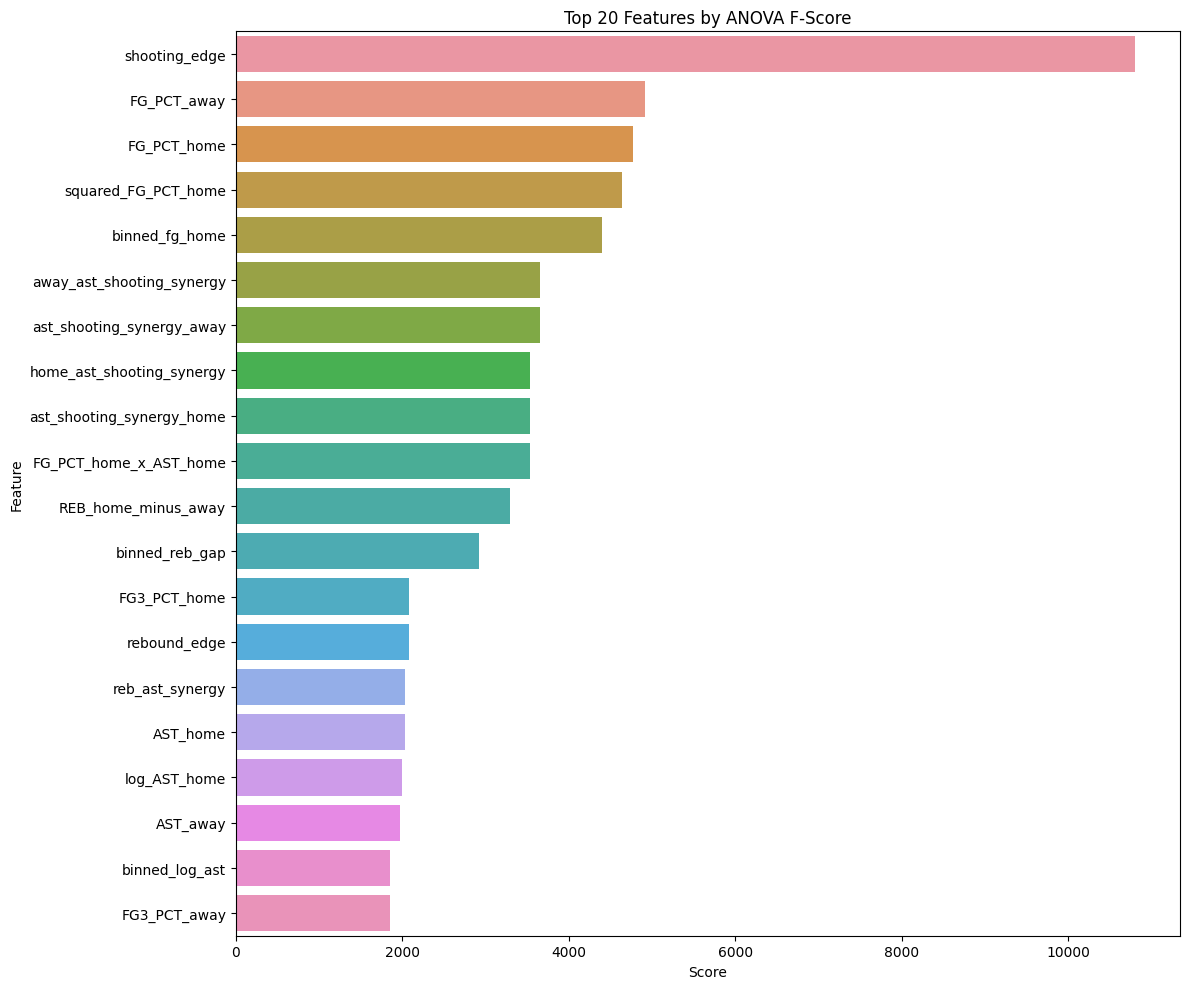

In [67]:
# Visualize top features
plt.figure(figsize=(12, 10))
sns.barplot(x='Score', y='Feature', data=anova_scores.head(20))
plt.title('Top 20 Features by ANOVA F-Score')
plt.tight_layout()
plt.savefig(figures_dir / "anova_top_features.png")
plt.show()

In [68]:
# Save scores
anova_scores.to_csv(output_dir / "anova_feature_scores.csv", index=False)

# Select features with p-value < 0.05
anova_features = anova_scores[anova_scores['P_value'] < 0.05]['Feature'].tolist()
print(f"ANOVA F-test selected {len(anova_features)} statistically significant features")
feature_sets['anova_filtered'] = anova_features
feature_sets['anova_top_30'] = anova_scores['Feature'].head(30).tolist()

ANOVA F-test selected 81 statistically significant features


## 2.2 Mutual Information
Mutual information captures non-linear relationships between features and the target.

In [69]:
# Mutual Information
col_names = X_train.columns 
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
X_train_scaled = pd.DataFrame(X_train_scaled_imputed, columns=X_train_scaled.columns)

selector = SelectKBest(score_func=mutual_info_classif, k=30)
selector.fit(X_train_scaled, y_train)

# Get scores
mi_scores = selector.scores_

# Create and sort dataframe by scores
mutual_info_scores = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Score': mi_scores
}).sort_values('Score', ascending=False)

print("Top 10 features by Mutual Information:")
print(mutual_info_scores.head(10))

Top 10 features by Mutual Information:
                      Feature     Score
64              shooting_edge  0.183026
5                 FG_PCT_home  0.108269
76        squared_FG_PCT_home  0.101298
11                FG_PCT_away  0.100923
55  away_ast_shooting_synergy  0.097821
81  ast_shooting_synergy_home  0.097587
82  ast_shooting_synergy_away  0.096870
54  home_ast_shooting_synergy  0.096294
58     FG_PCT_home_x_AST_home  0.094677
89             binned_fg_home  0.094030


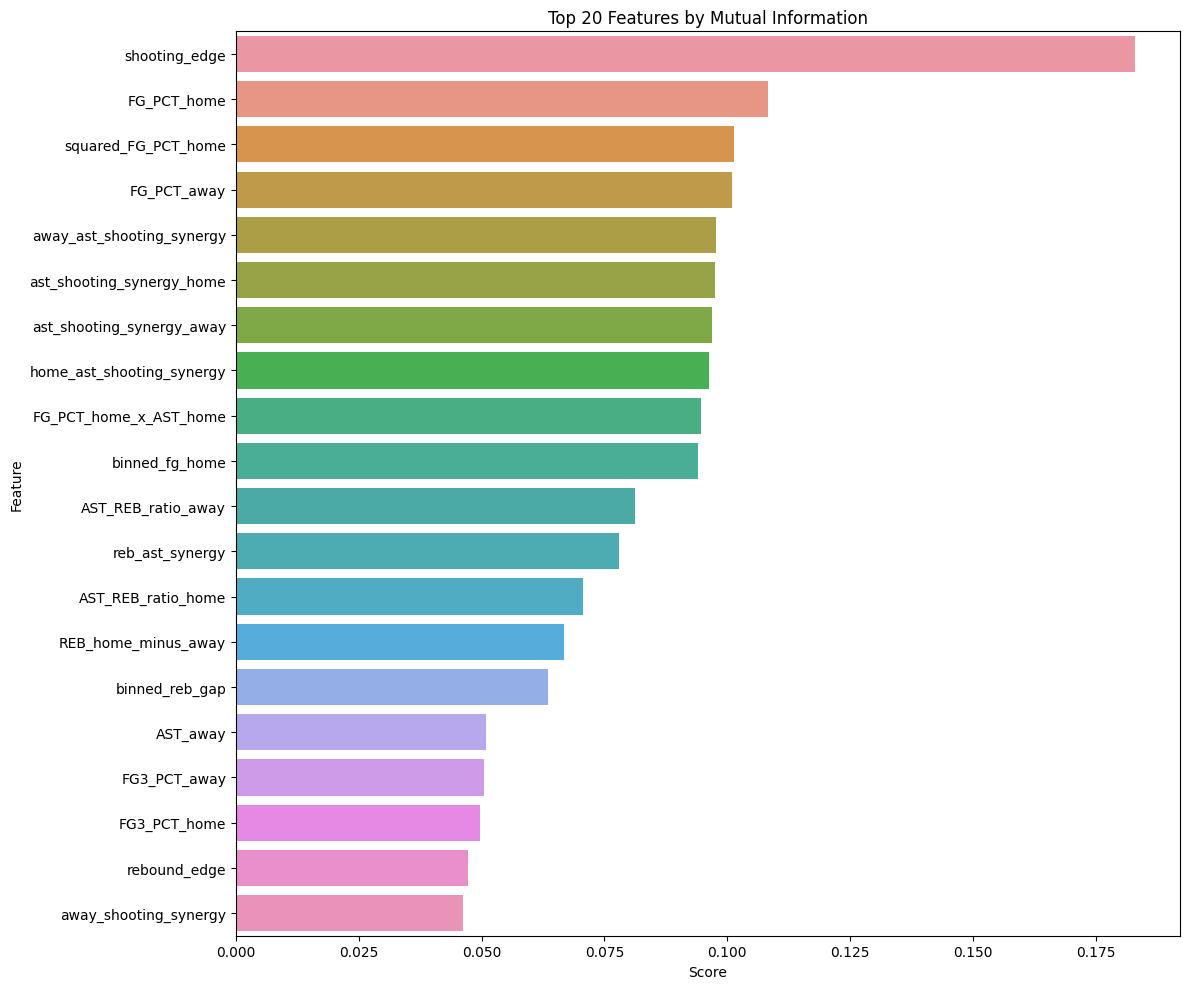

In [70]:
# Visualize top features
plt.figure(figsize=(12, 10))
sns.barplot(x='Score', y='Feature', data=mutual_info_scores.head(20))
plt.title('Top 20 Features by Mutual Information')
plt.tight_layout()
plt.savefig(figures_dir / "mutual_info_top_features.png")
plt.show()

In [71]:
# Save scores
mutual_info_scores.to_csv(output_dir / "mutual_info_feature_scores.csv", index=False)

In [72]:
# Select top k features
k = 30
mutual_info_features = mutual_info_scores.head(k)['Feature'].tolist()
print(f"Mutual information selected top {len(mutual_info_features)} features")
feature_sets['mutual_info_filtered'] = mutual_info_features

Mutual information selected top 30 features


## 2.3 Tree-based Feature Importance
Random Forest feature importance provides a measure of feature relevance based on how much each feature contributes to reducing impurity across all trees.

In [73]:
from sklearn.impute import SimpleImputer

# Impute missing values before training
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_imputed, y_train)

# Get feature importances
importances = rf.feature_importances_

# Create and sort dataframe by importance
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("Top 10 features by Random Forest importance:")
print(rf_importance.head(10))

Top 10 features by Random Forest importance:
                      Feature  Importance
70              shooting_edge    0.074669
11                FG_PCT_away    0.061714
5                 FG_PCT_home    0.042567
61  away_ast_shooting_synergy    0.040888
82        squared_FG_PCT_home    0.030435
88  ast_shooting_synergy_away    0.028223
87  ast_shooting_synergy_home    0.027052
65        REB_home_minus_away    0.026434
85         asymmetry_shooting    0.022859
64     FG_PCT_home_x_AST_home    0.022523


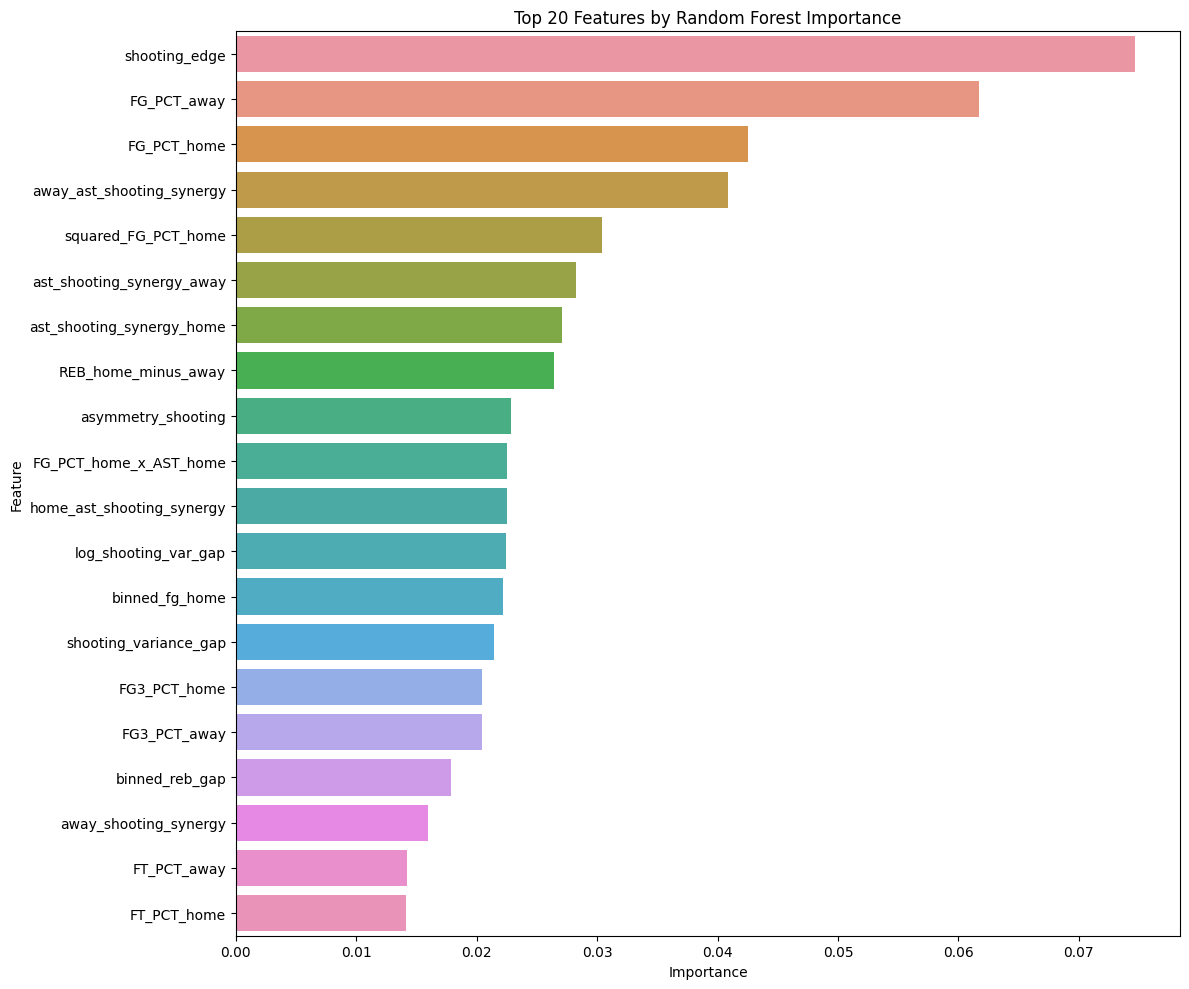

In [74]:
# Visualize top features
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=rf_importance.head(20))
plt.title('Top 20 Features by Random Forest Importance')
plt.tight_layout()
plt.savefig(figures_dir / "rf_top_features.png")
plt.show()

In [75]:
# Save importances
rf_importance.to_csv(output_dir / "rf_feature_importance.csv", index=False)

In [76]:
# Impute missing values before feature selection
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

# Use SelectFromModel to pick important features
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(rf, threshold='median')
selector.fit(X_train_imputed, y_train)

# Get selected feature names
selected_indices = selector.get_support(indices=True)
rf_features = X.columns[selected_indices].tolist()

print(f"Random Forest importance filtering selected {len(rf_features)} features")
feature_sets['rf_importance_filtered'] = rf_features

Random Forest importance filtering selected 49 features


In [77]:
# Train an XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Get feature importances
xgb_importances = xgb_model.feature_importances_

# Create and sort dataframe by importance
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_importances
}).sort_values('Importance', ascending=False)

print("Top 10 features by XGBoost importance:")
print(xgb_importance.head(10))

Top 10 features by XGBoost importance:
                      Feature  Importance
70              shooting_edge    0.690597
62      shooting_variance_gap    0.031040
65        REB_home_minus_away    0.016120
53                win_pct_gap    0.011730
7                FG3_PCT_home    0.007765
13               FG3_PCT_away    0.007295
6                 FT_PCT_home    0.007233
12                FT_PCT_away    0.007226
89            reb_ast_synergy    0.005937
61  away_ast_shooting_synergy    0.005843


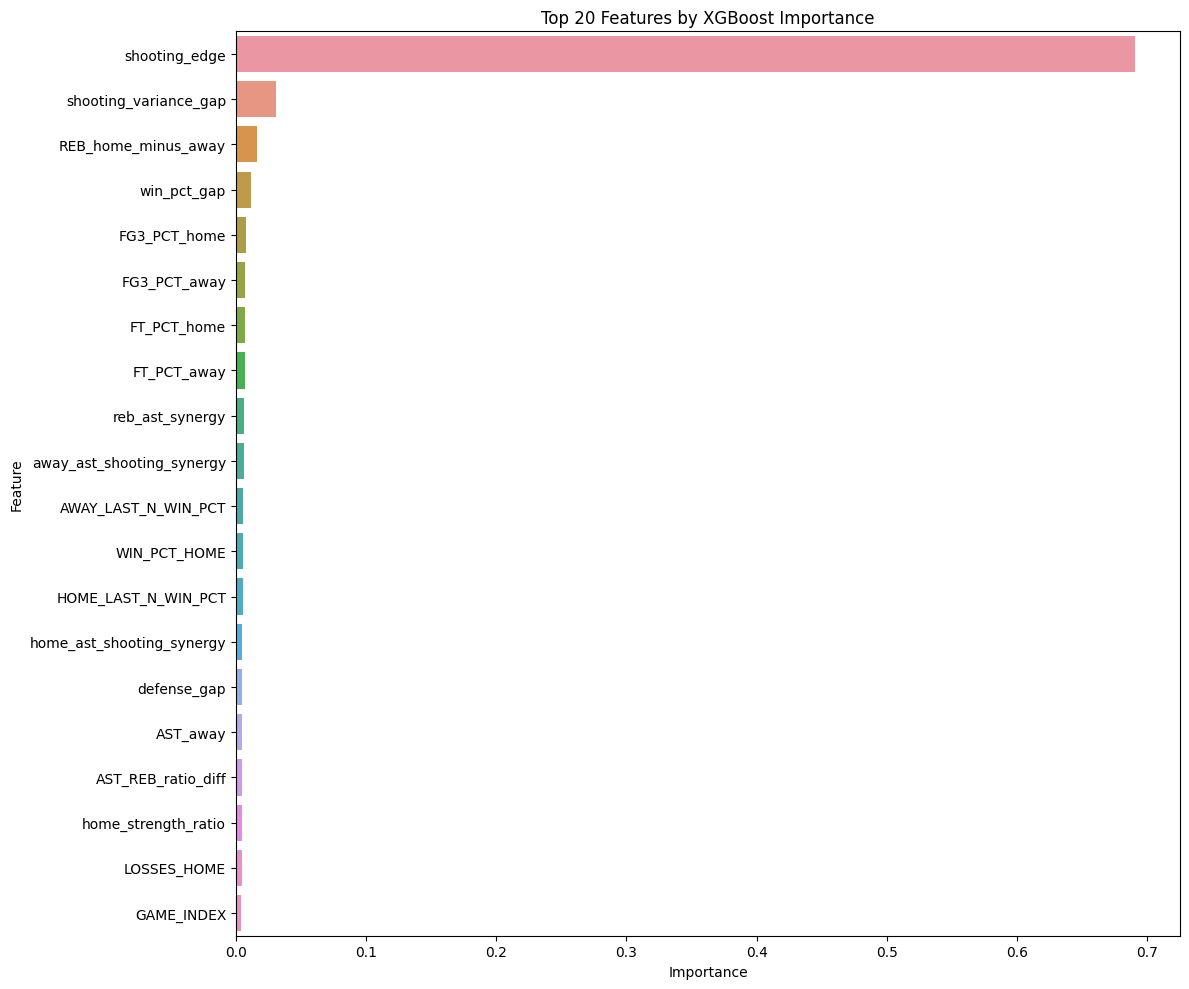

In [78]:
# Visualize top features
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=xgb_importance.head(20))
plt.title('Top 20 Features by XGBoost Importance')
plt.tight_layout()
plt.savefig(figures_dir / "xgb_top_features.png")
plt.show()

In [79]:
# Save importances
xgb_importance.to_csv(output_dir / "xgb_feature_importance.csv", index=False)

In [80]:
# Select features with importance > threshold
threshold = 0.01
xgb_features = xgb_importance[xgb_importance['Importance'] > threshold]['Feature'].tolist()

print(f"XGBoost importance filtering selected {len(xgb_features)} features")
feature_sets['xgb_importance_filtered'] = xgb_features

XGBoost importance filtering selected 4 features


## 2.4 Recursive Feature Elimination (RFE)
RFE works by recursively removing features, building a model using the remaining features, and ranking them.

In [81]:
# Drop leakage columns
leakage_cols = ["GAME_ID", "GAME_INDEX", "HOME_TEAM_ID", "SEASON", "VISITOR_TEAM_ID", "TEAM_ID_home", "TEAM_ID_away"]
X = df.drop(columns=leakage_cols + ["HOME_TEAM_WINS"])
y = df["HOME_TEAM_WINS"]

# Keep numeric columns only
X = X.select_dtypes(include=["number"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Impute and scale
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
# Drop columns with all NaNs
all_nan_cols = X_train.columns[X_train.isna().all()]
if not all_nan_cols.empty:
    print("Dropping all-NaN columns:", list(all_nan_cols))
    X_train.drop(columns=all_nan_cols, inplace=True)
    X_test.drop(columns=all_nan_cols, inplace=True)

# Impute
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_train.columns)

# Scale
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Apply RFE
estimator = LogisticRegression(max_iter=1000, random_state=42)
selector = RFE(estimator, n_features_to_select=30)
selector.fit(X_train_scaled_df, y_train)

# Rankings
rfe_features = X_train_scaled_df.columns[selector.support_].tolist()
rankings = pd.DataFrame({
    'Feature': X_train_scaled_df.columns,
    'Ranking': selector.ranking_
}).sort_values('Ranking')
print(rankings['Ranking'].value_counts().sort_index())

Dropping all-NaN columns: ['AVG_FG_PCT_HOME', 'AVG_FG_PCT_AWAY']
Ranking
1     30
2      1
3      1
4      1
5      1
      ..
58     1
59     1
60     1
61     1
62     1
Name: count, Length: 62, dtype: int64


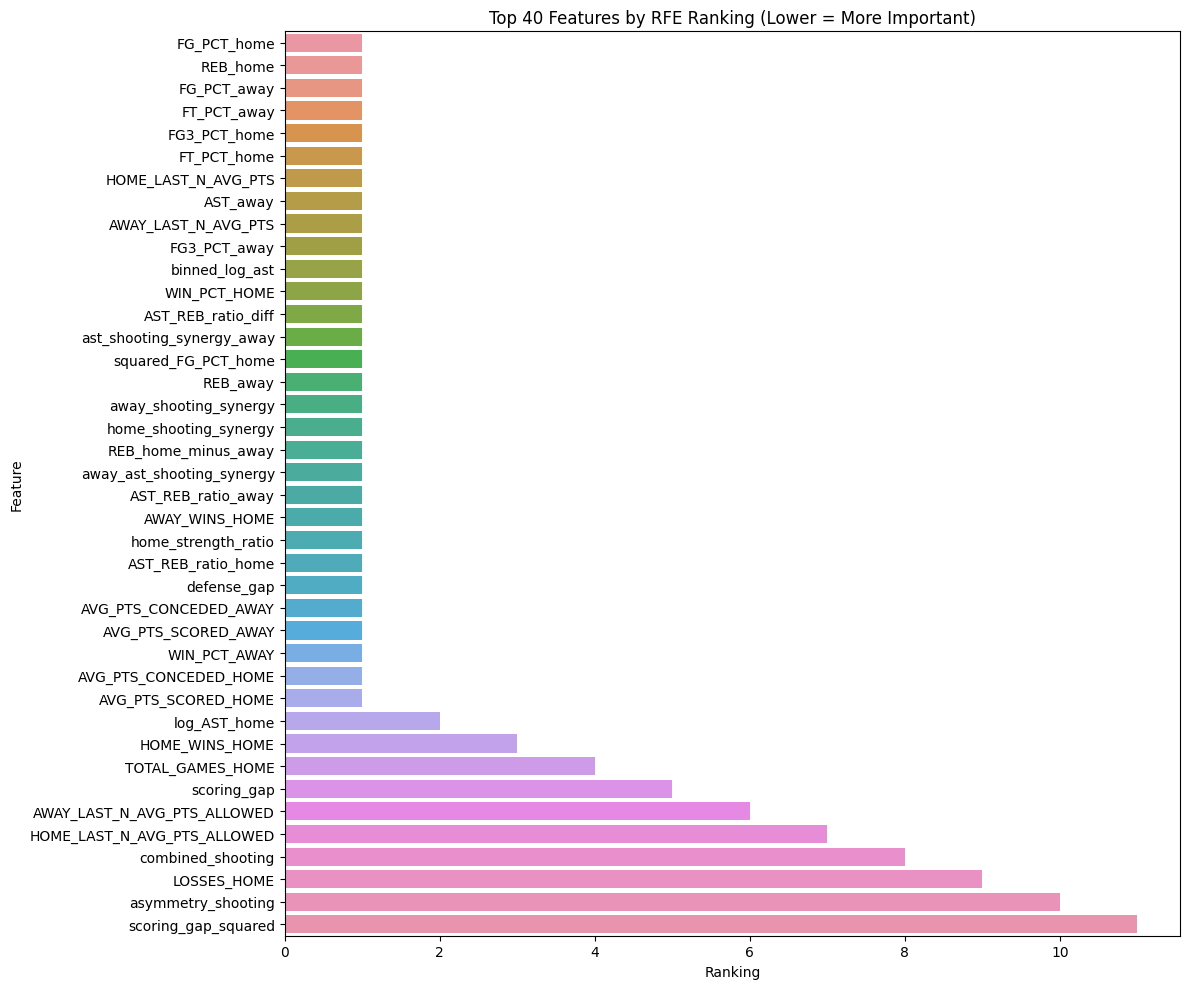

In [83]:
# Show a mix of selected and unselected
top_40_varied = rankings.sort_values('Ranking').head(40)

plt.figure(figsize=(12, 10))
sns.barplot(x='Ranking', y='Feature', data=top_40_varied)
plt.title('Top 40 Features by RFE Ranking (Lower = More Important)')
plt.tight_layout()
plt.savefig(figures_dir / "rfe_top_features.png")
plt.show()


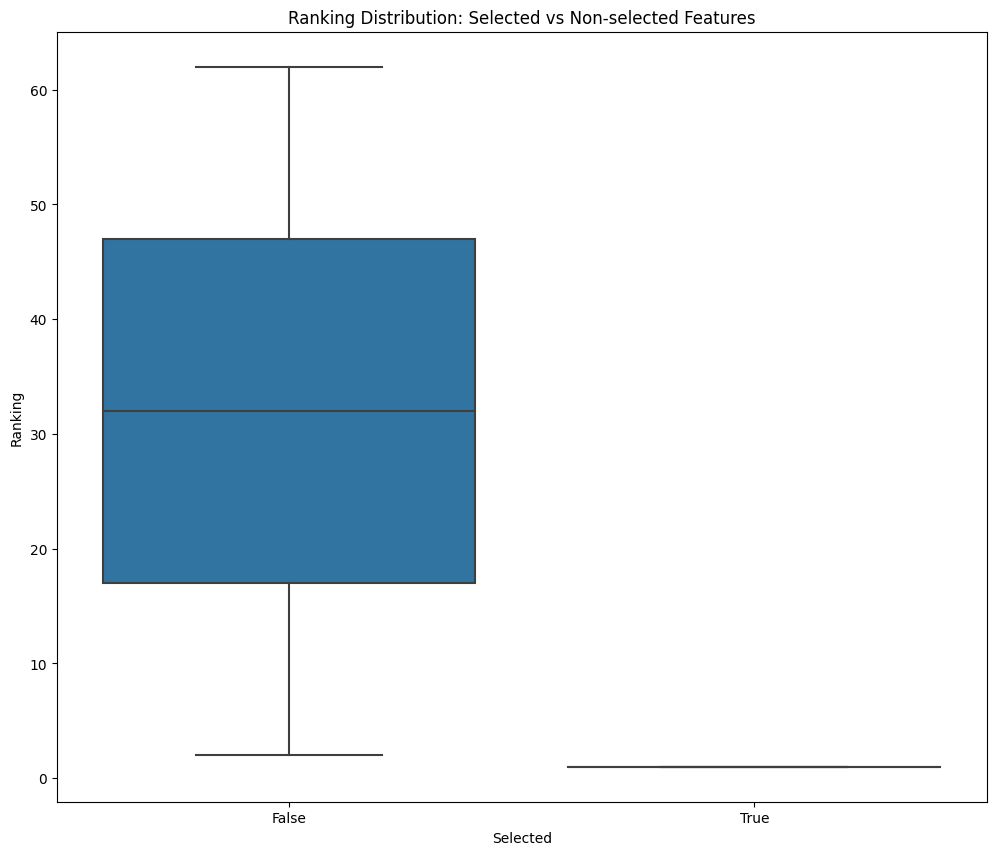

In [84]:
rankings['Selected'] = (rankings['Ranking'] == 1)

plt.figure(figsize=(12, 10))
sns.boxplot(x='Selected', y='Ranking', data=rankings)
plt.title('Ranking Distribution: Selected vs Non-selected Features')
plt.show()

In [85]:
# Save rankings
rankings.to_csv(output_dir / "rfe_feature_rankings.csv", index=False)

In [86]:
print(f"RFE selected {len(rfe_features)} features")
feature_sets['rfe_filtered'] = rfe_features

RFE selected 30 features


## 2.5 Principal Component Analysis (PCA)
PCA reduces dimensionality by transforming the data into a new coordinate system while preserving as much variance as possible.

In [93]:
# Imputing
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Get column names after imputation
valid_columns = X_train.columns[~np.all(X_train.isna(), axis=0)]

# Wrap imputed data into DataFrame using only valid columns
X_train_df = pd.DataFrame(X_train_imputed, columns=valid_columns)
X_test_df = pd.DataFrame(X_test_imputed, columns=valid_columns)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Report
print(f"PCA retained {pca.n_components_} components explaining 95% of variance")
print(f"Shape before PCA: {X_train_scaled.shape}, after PCA: {X_train_pca.shape}")

PCA retained 32 components explaining 95% of variance
Shape before PCA: (20846, 91), after PCA: (20846, 32)


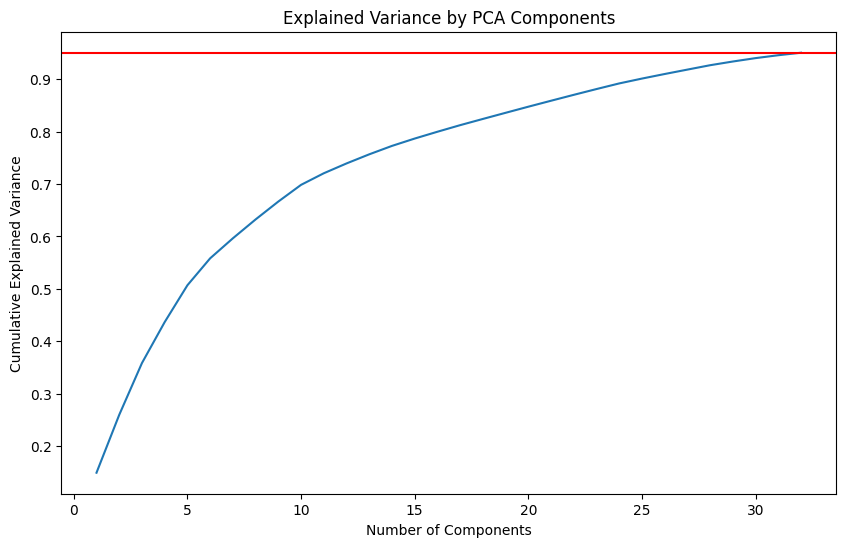

In [94]:
# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.savefig(figures_dir / "pca_explained_variance.png")
plt.show()

In [95]:
# Save component information
explained_variance = pca.explained_variance_ratio_
component_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained_Variance': explained_variance,
    'Cumulative_Variance': cumulative_variance
})
component_df.to_csv(output_dir / "pca_components.csv", index=False)
component_df.head(10)

,Component,Explained_Variance,Cumulative_Variance
0,PC1,0.149271,0.149271
1,PC2,0.110428,0.259699
2,PC3,0.098798,0.358497
3,PC4,0.078149,0.436645
4,PC5,0.070256,0.506902
5,PC6,0.051356,0.558258
6,PC7,0.038190,0.596448
7,PC8,0.035999,0.632447
8,PC9,0.034125,0.666571
9,PC10,0.031852,0.698423


In [96]:
# Feature contribution to principal components
feature_contributions = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=valid_columns
)
feature_contributions.to_csv(output_dir / "pca_feature_contributions.csv")

# Display the top contributing features to the first 3 components
top_features_per_component = {}
for i in range(min(3, pca.n_components_)):
    component = f'PC{i+1}'
    # Get absolute contributions and sort
    abs_contributions = feature_contributions[component].abs().sort_values(ascending=False)
    top_features_per_component[component] = abs_contributions.head(5)
    
    print(f"\nTop 5 features contributing to {component}:")
    for feature, contribution in abs_contributions.head(5).items():
        print(f"- {feature}: {contribution:.4f}")


Top 5 features contributing to PC1:
- home_ast_shooting_synergy: 0.2582
- ast_shooting_synergy_home: 0.2582
- FG_PCT_home_x_AST_home: 0.2582
- AST_home: 0.2384
- reb_ast_synergy: 0.2384

Top 5 features contributing to PC2:
- home_strength_ratio: 0.2482
- WINS_AWAY: 0.2063
- WIN_PCT_AWAY: 0.2062
- HOME_WINS_AWAY: 0.2039
- AWAY_WINS_AWAY: 0.2034

Top 5 features contributing to PC3:
- WIN_PCT_HOME: 0.2766
- WINS_HOME: 0.2748
- AWAY_WINS_HOME: 0.2738
- LOSSES_HOME: 0.2719
- HOME_WINS_HOME: 0.2693


In [97]:
feature_sets['pca_transformed'] = [f'PC{i+1}' for i in range(pca.n_components_)]

In [98]:
# Top 20 absolute contributors to first 3 components
pca_top_features = set()
for i in range(min(3, pca.n_components_)):
    component = f'PC{i+1}'
    abs_contribs = feature_contributions[component].abs().sort_values(ascending=False)
    pca_top_features.update(abs_contribs.head(20).index.tolist())

# Save as its own method
feature_sets["pca_top_features"] = list(pca_top_features)

## 2.6 t-SNE Visualization
t-SNE is a dimensionality reduction technique particularly well suited for visualization of high-dimensional datasets.

In [104]:
# Apply t-SNE for visualization
def tsne_visualize(X_train_scaled, y_train):
    """Apply t-SNE to visualize feature space"""
    try:
        # Initialize t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        
        # We'll use a sample if dataset is large
        max_samples = 5000
        if X_train_scaled.shape[0] > max_samples:
            # Random sample
            indices = np.random.choice(X_train_scaled.shape[0], max_samples, replace=False)
            X_sample = X_train_scaled[indices]
            y_sample = y_train.iloc[indices]
        else:
            X_sample = X_train_scaled
            y_sample = y_train
        
        # Fit and transform
        X_tsne = tsne.fit_transform(X_sample)
        
        # Create dataframe for plotting
        tsne_df = pd.DataFrame({
            'x': X_tsne[:, 0],
            'y': X_tsne[:, 1],
            'target': y_sample
        })
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='x', y='y', hue='target', data=tsne_df, palette='viridis')
        plt.title('t-SNE Visualization of Feature Space')
        plt.savefig(figures_dir / "tsne_visualization.png")
        plt.show()
        
        print("t-SNE visualization created")
        return X_tsne
    except Exception as e:
        print(f"Error in t-SNE visualization: {e}")
        return None

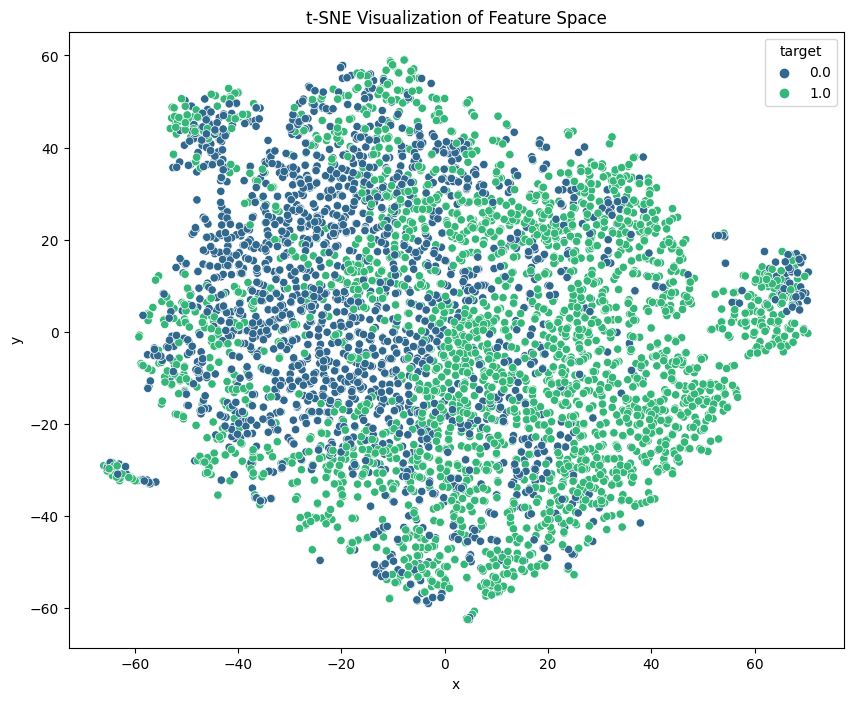

t-SNE visualization created


In [105]:
# Run t-SNE visualization
tsne_result = tsne_visualize(X_train_scaled, y_train)

# 3 Feature Set Analysis
Now we'll analyze the different feature sets and create consensus feature sets.

In [107]:
# Common features across multiple methods
methods = ['anova_filtered', 'mutual_info_filtered',
    'rf_importance_filtered', 'xgb_importance_filtered', 'rfe_filtered',
    'pca_top_features']

# Count how many methods selected each feature
feature_counts = {}
for method in methods:
    for feature in feature_sets[method]:
        feature_counts[feature] = feature_counts.get(feature, 0) + 1

In [109]:
# Features selected by at least N methods
for n in range(2, len(methods) + 1):
    # Select features chosen by at least n methods
    consensus_features = [feature for feature, count in feature_counts.items() if count >= n]
    feature_sets[f'consensus_{n}_methods'] = consensus_features
    print(f"Features selected by at least {n} methods: {len(consensus_features)}")


Features selected by at least 2 methods: 72
Features selected by at least 3 methods: 40
Features selected by at least 4 methods: 26
Features selected by at least 5 methods: 9
Features selected by at least 6 methods: 0


In [110]:
# Create a comprehensive view of which features are selected by which methods
all_features = set()
for method in methods:
    all_features.update(feature_sets[method])

feature_selection_matrix = pd.DataFrame(index=sorted(all_features))

for method in methods:
    feature_selection_matrix[method] = feature_selection_matrix.index.isin(feature_sets[method])

# Count how many methods selected each feature
feature_selection_matrix['selection_count'] = feature_selection_matrix.sum(axis=1)
feature_selection_matrix = feature_selection_matrix.sort_values('selection_count', ascending=False)

In [111]:
# Save the feature selection matrix
feature_selection_matrix.to_csv(output_dir / "feature_selection_matrix.csv")
feature_selection_matrix.head(20)

,anova_filtered,mutual_info_filtered,rf_importance_filtered,xgb_importance_filtered,rfe_filtered,pca_top_features,selection_count
REB_home_minus_away,True,True,True,True,True,False,5
AST_REB_ratio_home,True,True,True,False,True,True,5
ast_shooting_synergy_away,True,True,True,False,True,True,5
away_ast_shooting_synergy,True,True,True,False,True,True,5
FG3_PCT_home,True,True,True,False,True,True,5
AST_REB_ratio_diff,True,True,True,False,True,True,5
squared_FG_PCT_home,True,True,True,False,True,True,5
FG_PCT_home,True,True,True,False,True,True,5
home_shooting_synergy,True,True,True,False,True,True,5
home_ast_shooting_synergy,True,True,True,False,False,True,4


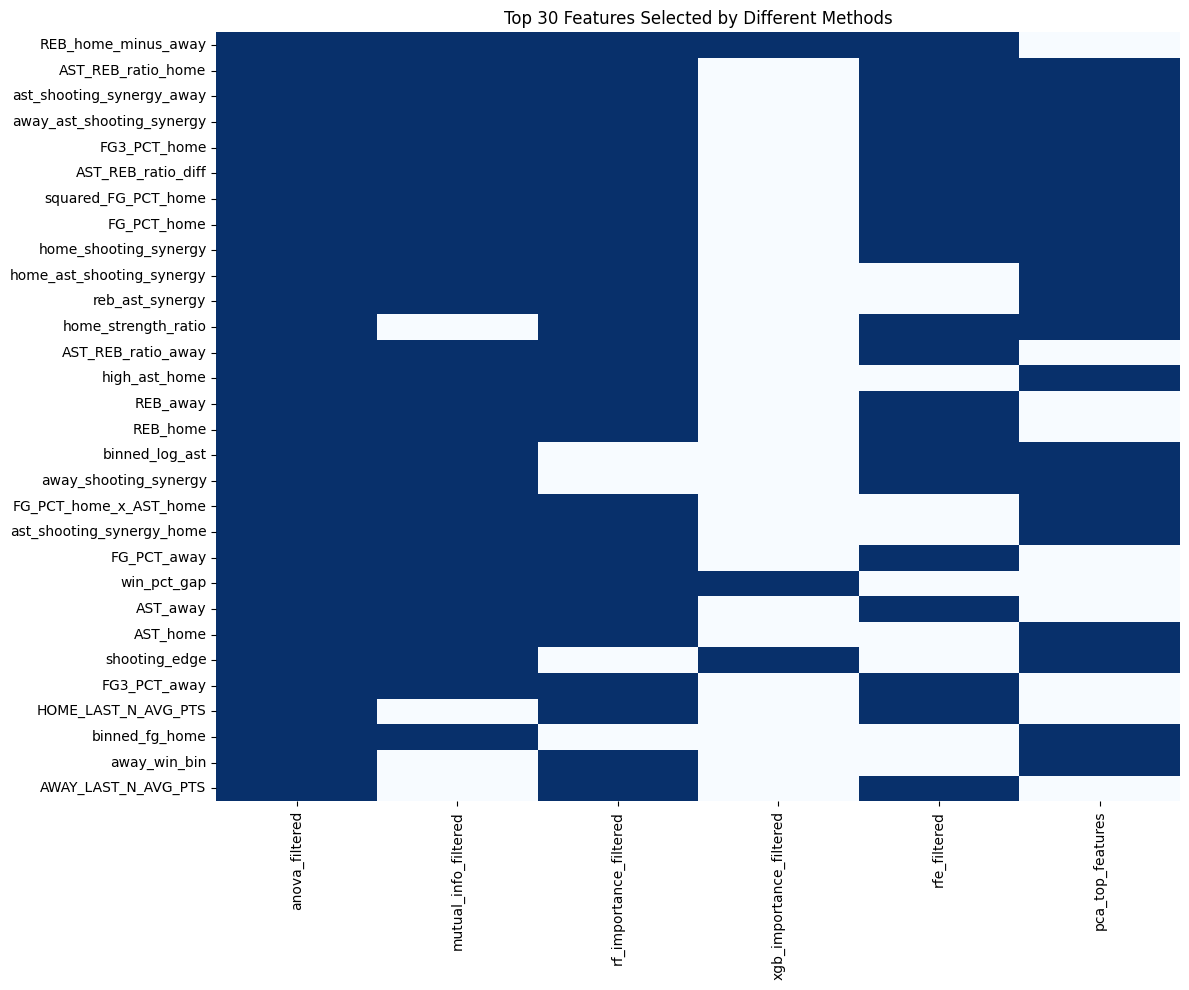

In [112]:
# Visualize feature selection overlap
plt.figure(figsize=(12, 10))
sns.heatmap(feature_selection_matrix[methods].head(30), cmap='Blues', cbar=False)
plt.title('Top 30 Features Selected by Different Methods')
plt.tight_layout()
plt.savefig(figures_dir / "feature_selection_overlap.png")
plt.show()

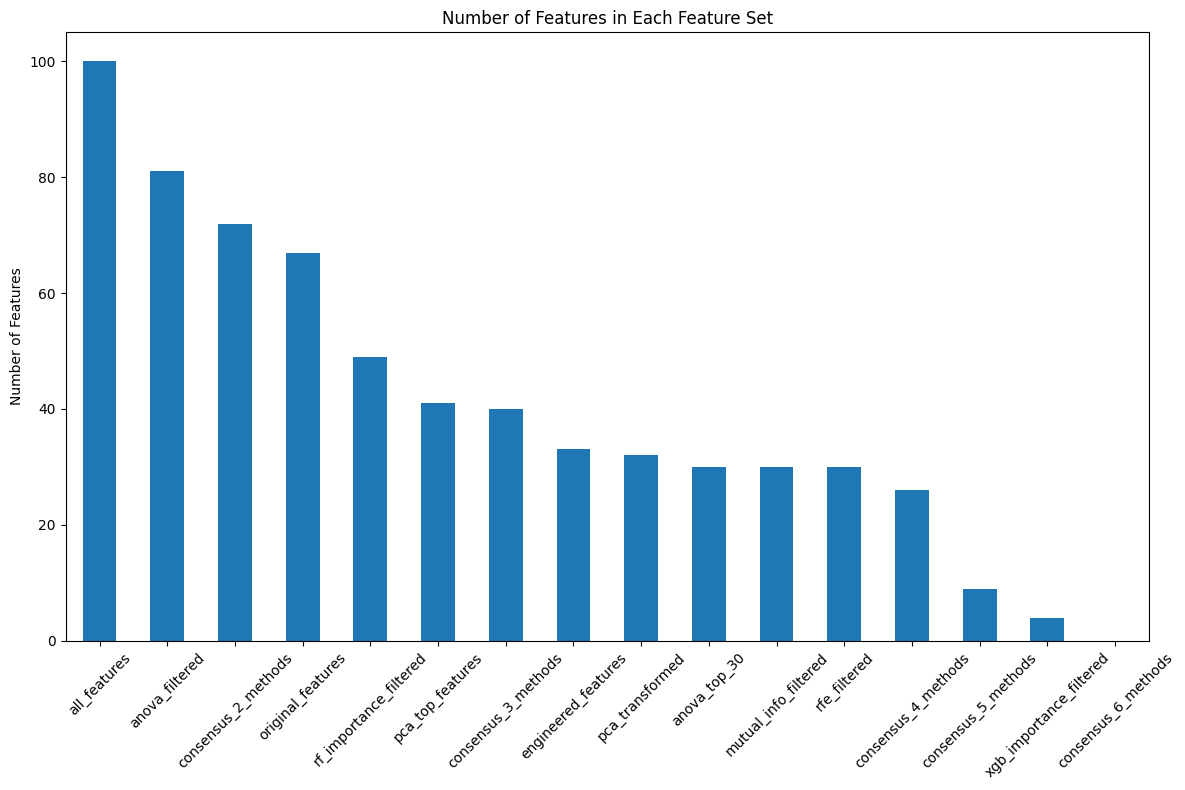

In [114]:
# Show feature set sizes
feature_set_sizes = {key: len(value) for key, value in feature_sets.items()}
feature_set_sizes = pd.Series(feature_set_sizes).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_set_sizes.plot(kind='bar')
plt.title('Number of Features in Each Feature Set')
plt.ylabel('Number of Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(figures_dir / "feature_set_sizes.png")
plt.show()

# 4. Save Feature Sets for Model Training

In [115]:
# Save feature sets
with open(output_dir / 'feature_sets.pkl', 'wb') as f:
    pickle.dump(feature_sets, f)

# Save as csv as well for reference
feature_sets_df = pd.DataFrame({
    'feature_set': list(feature_sets.keys()),
    'num_features': [len(feature_set) for feature_set in feature_sets.values()]
})
feature_sets_df.to_csv(output_dir / "feature_sets_summary.csv", index=False)
feature_sets_df

,feature_set,num_features
0,all_features,100
1,original_features,67
2,engineered_features,33
3,anova_filtered,81
4,anova_top_30,30
5,mutual_info_filtered,30
6,rf_importance_filtered,49
7,xgb_importance_filtered,4
8,rfe_filtered,30
9,pca_transformed,32


In [116]:
# Save each feature set as a separate csv
for name, features in feature_sets.items():
    pd.Series(features).to_csv(output_dir / f"{name}.csv", index=False, header=['feature'])
print(f"All feature sets saved to {output_dir}")
print(f"Visualizations saved to {figures_dir}")

All feature sets saved to model_results\consensus_features
Visualizations saved to figures\model_results\consensus_features


# 5. Summary

In [117]:
print(f"Created {len(feature_sets)} different feature sets")
for name, features in feature_sets.items():
    print(f"- {name}: {len(features)} features")

corr_filtered_features = selected_features
feature_sets["correlation_filtered"] = corr_filtered_features
feature_sets["anova_top_30"] = anova_scores['Feature'].head(30).tolist()
feature_sets["mutual_info_top_30"] = mutual_info_scores['Feature'].head(30).tolist()
feature_sets["rf_top_30"] = rf_importance['Feature'].head(30).tolist()
# Save for use in modeling notebook
import pickle

Path("selected_features").mkdir(parents=True, exist_ok=True)

with open("selected_features/feature_sets.pkl", "wb") as f:
    pickle.dump(feature_sets, f)

print("Feature sets saved to selected_features/feature_sets.pkl")

Created 16 different feature sets
- all_features: 100 features
- original_features: 67 features
- engineered_features: 33 features
- anova_filtered: 81 features
- anova_top_30: 30 features
- mutual_info_filtered: 30 features
- rf_importance_filtered: 49 features
- xgb_importance_filtered: 4 features
- rfe_filtered: 30 features
- pca_transformed: 32 features
- pca_top_features: 41 features
- consensus_2_methods: 72 features
- consensus_3_methods: 40 features
- consensus_4_methods: 26 features
- consensus_5_methods: 9 features
- consensus_6_methods: 0 features
Feature sets saved to selected_features/feature_sets.pkl


### Feature Selection Justification for Modeling

Throughout the feature selection phase, a wide range of techniques were applied to understand the structure, importance, and discriminative power of various features. These included:

- **Filter methods**: Mutual Information, ANOVA F-test, Correlation Thresholding  
- **Wrapper methods**: Recursive Feature Elimination (RFE)  
- **Embedded methods**: XGBoost Feature Importance  
- **Unsupervised techniques**: Principal Component Analysis (PCA)  
- **Consensus methods**: Intersection-based agreement across multiple selectors  

Despite this comprehensive exploration, the final modeling phase intentionally focuses on **only a subset of these feature sets**. This decision was guided by three key goals:

---

#### 1. Fair Model Comparison

Some feature selection techniques are inherently **model-dependent** (e.g., XGBoost importance). Using such features introduces **bias** into model evaluation — for instance, XGBoost-selected features are likely to benefit XGBoost more than Logistic Regression.

To maintain fairness across models, we selected only **model-agnostic feature sets**:
- Mutual Information (nonlinear dependencies)
- ANOVA F-test (statistical discrimination)
- RFE (recursive refinement with logistic regression)
- PCA (model-independent compression)
---

#### 2. Dimensionality Control

High-dimensional sets (e.g., consensus feature unions or unfiltered full datasets) can cause:
- **Overfitting**, especially with tree-based and neural models
- **Computational burden** during cross-validation and tuning
- **Interpretability loss**, which is crucial for simpler models like Logistic Regression

By limiting each feature set to ~30 features, we ensured models remain interpretable, fast, and generalizable.

---

#### 3. Balanced Coverage of Feature Properties

The four selected sets were intentionally chosen to span **different philosophies of feature engineering**:

| Feature Set         | Method Type        | Strength                                                     |
|---------------------|--------------------|--------------------------------------------------------------|
| `mutual_info_filtered` | Nonlinear Filter   | Captures complex, nonlinear associations                    |
| `anova_top_30`         | Statistical Filter | Measures class separation via variance                      |
| `rfe_filtered`         | Wrapper            | Iteratively refines top predictors using logistic regression |
| `pca_transformed`      | Unsupervised       | Compresses features while preserving max variance           |

This diversity enables a fair test of both **linear and nonlinear models**, while keeping results interpretable and compact.

---

### Conclusion

While other feature sets (e.g., consensus-based, XGBoost-selected) could be valuable, the chosen sets strike a **practical balance between fairness, performance, and generalization**. This strategy ensures that modeling results are:

- **Model-agnostic**  
- **Statistically grounded**  
- **Interpretable and reproducible**  

These final feature sets form the foundation of our core modeling pipeline and performance benchmarking.